In [ ]:
library(Seurat)
library(ggplot2)
library(dplyr)
library(patchwork)
library(stringr)
library(ggplot2)

In [2]:
## https://drive.google.com/file/d/1lzCmtd7nihnCfX7vRLWNeb1a0Etgo8ol/view?usp=drive_link
seu_obj <- readRDS(file="/project/zhuzhuzhang/lyang/scaleBio_RNA_rat_brain/out_mRatBN/merged_seurat_obj_DF_removed_2.rds")

## Finding DEFs

In [9]:
library(RColorBrewer)

In [10]:
## gene markers used for visualization
sel.gene <- c( 'Slc17a7', 'Lingo1', 'Sv2b', 'Neurod6', 'Kcnma1', ## pan-Exc
                'Prex1', 'Cux2','Rnf144a','Enpp2','Zfp462', ## IT-L23
                'Foxo3', 'Rorb','Kcnh5','Tspan11','Cadps2', ## IT-L4
                'Ptgfrn', 'Pip4k2a', 'Susd5','Opn3','Sulf2', ## IT-L5
                'Xkr7', 'Mgat5','Susd4','Adamts3','Npas2', ## IT-L6
                'Tcerg1l', 'Khdrbs2', 'Ralgapa2','L3mbtl4','Vat1l',## ET-L5
                'Tle4', 'Syt6', 'Arhgap25', 'Rnf152', 'Kcnk3', ## CT-L6
                 'Galnt10', 'Hipk2', 'Kcnab1', 'Dlg5', 'Gng12', ## L6b
                'Gad1', 'Gad2', 'Abat', 'Slc6a1', 'Stat5b', ## Pan-Inh
                'Pvalb', 'Man1c1', 'Cemip',## MGE-Pvalb
                'Sst', 'Grin3a','Grik3', ## MGE-Sst
                'Vip', 'Vav2','Npas3', ## CGE-Vip
                'Lamp5', 'Pip5k1b', 'Fgf13',## CGE-Lamp5
                'Slc1a2', 'Trim9', 'Paqr8', 'Cpe', 'Slc1a3', ## ASC
                'Mobp', 'Mbp', 'Mog', 'Pde4b', 'Klh12', ## ODC
                'Pdgfra', 'Xylt1', 'Chst11', 'Cacng4', 'Tnr', ## OPC
                'Csf1r', 'P2ry13', 'Fcrls', 'Zfp710', 'Laptm5' ## MGC
                )

Warning message:
“‘timedatectl’ indicates the non-existent timezone name ‘n/a’”
unable to deduce timezone name from ‘America/Chicago’

Warning message:
“The following features were omitted as they were not found:
ℹ Klh12 and Fcrls”


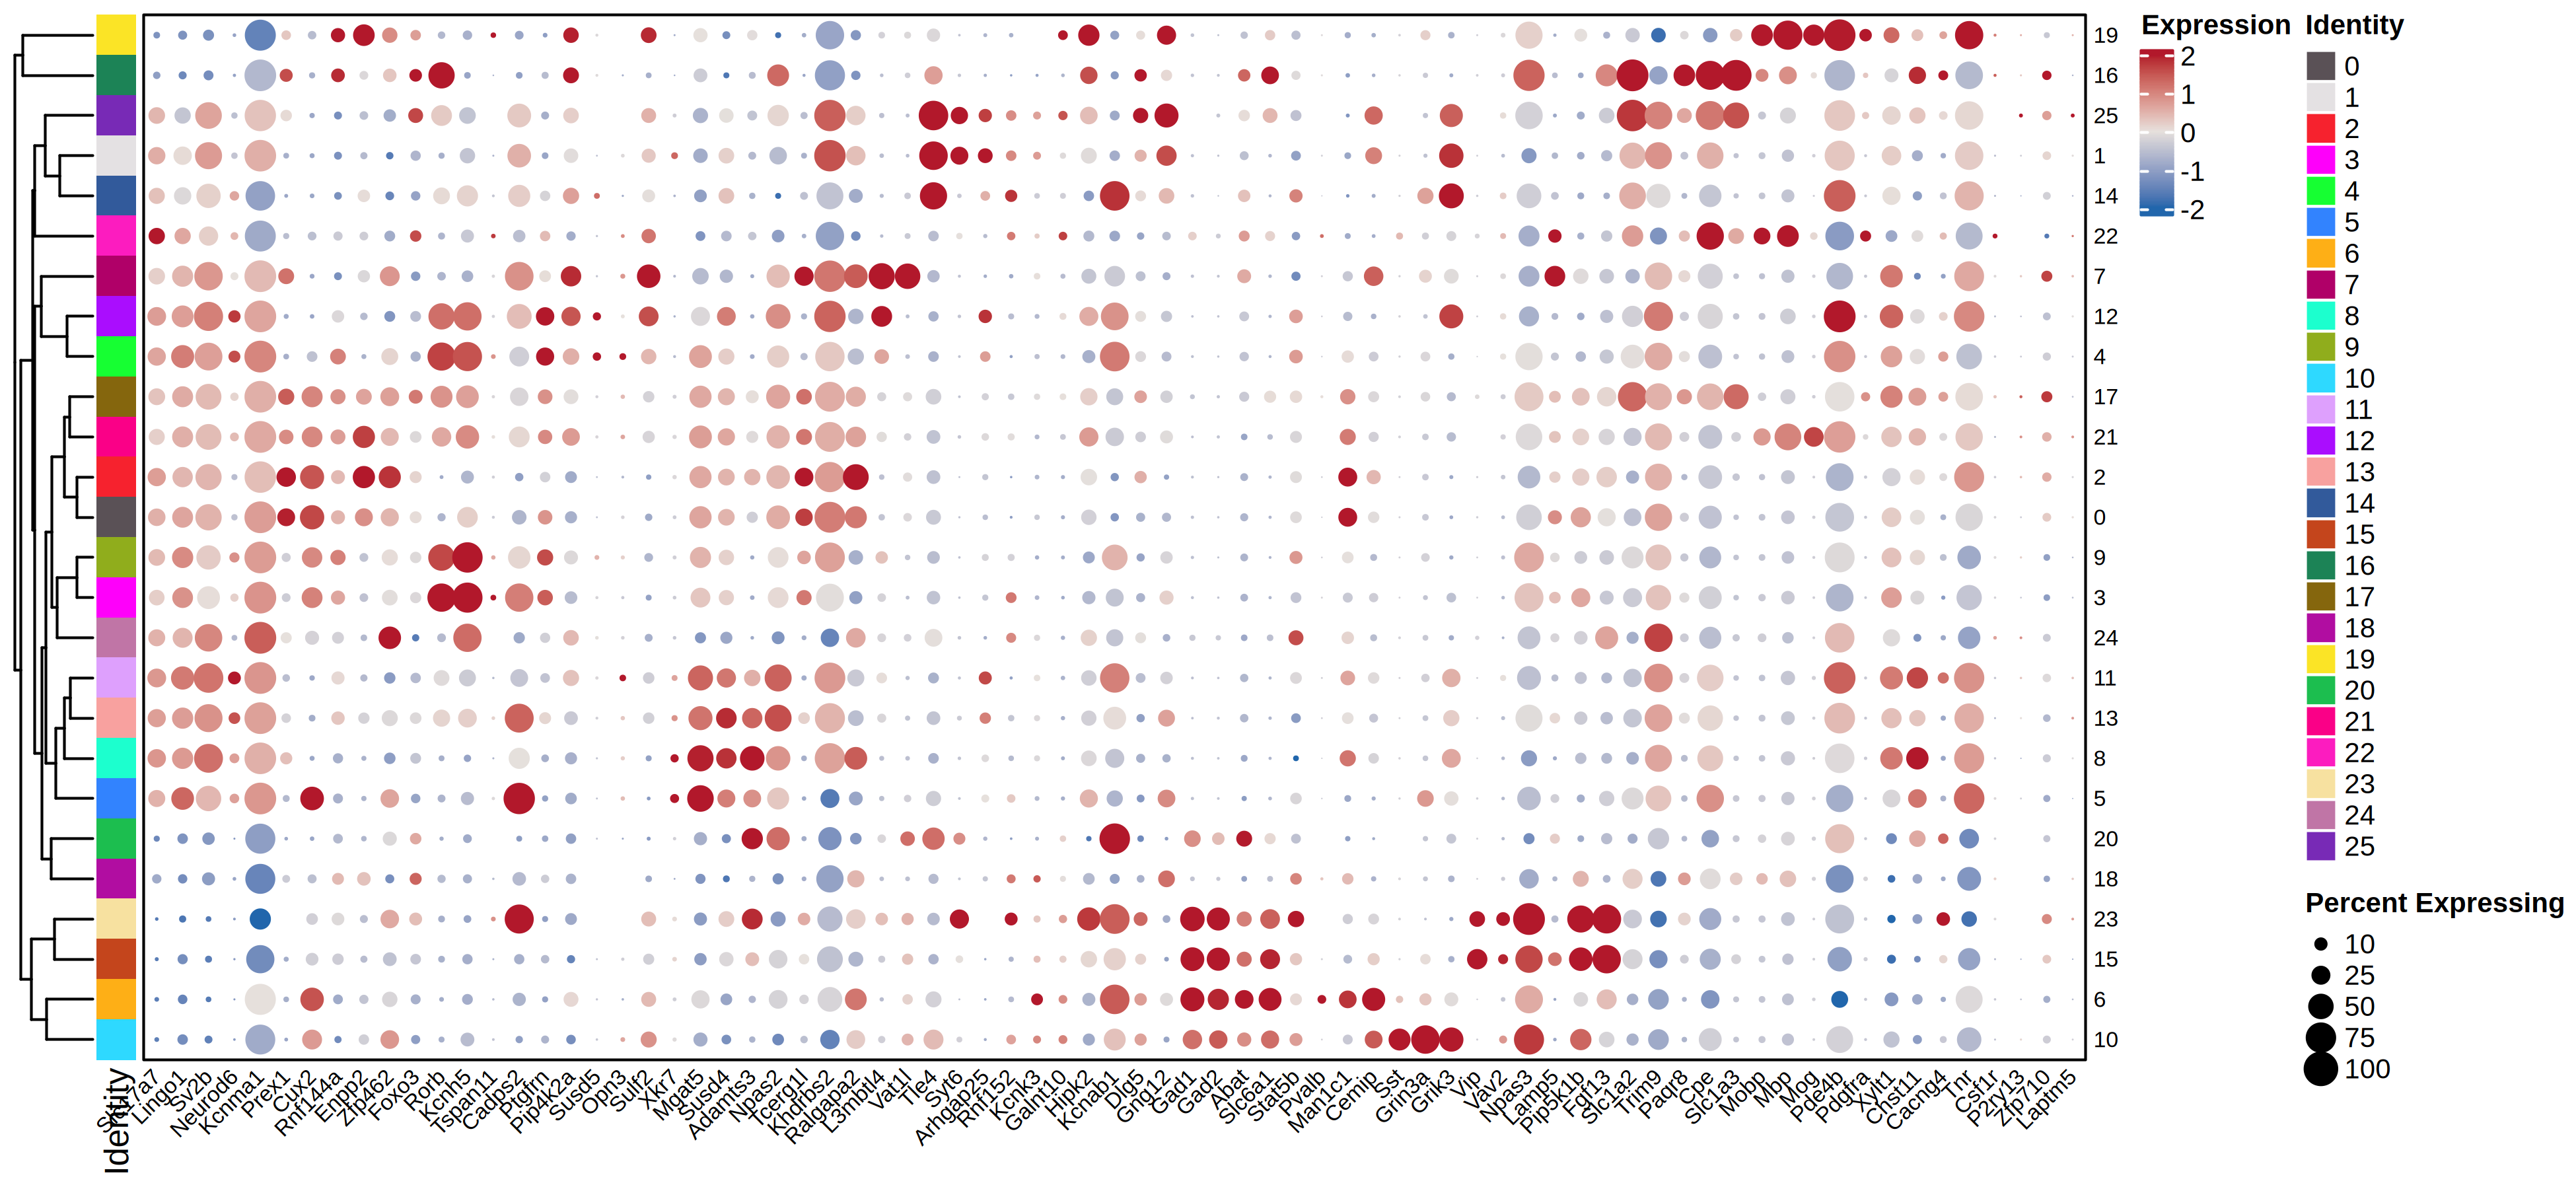

In [11]:
options(repr.plot.width = 13, repr.plot.height = 6, repr.plot.res = 300)
scCustomize::Clustered_DotPlot(seu_obj, features = unique(sel.gene),
                               plot_km_elbow = FALSE, flip = TRUE,cluster_feature = FALSE,
                               colors_use_exp=rev(colorRampPalette(brewer.pal(8, "RdBu"))(250)))

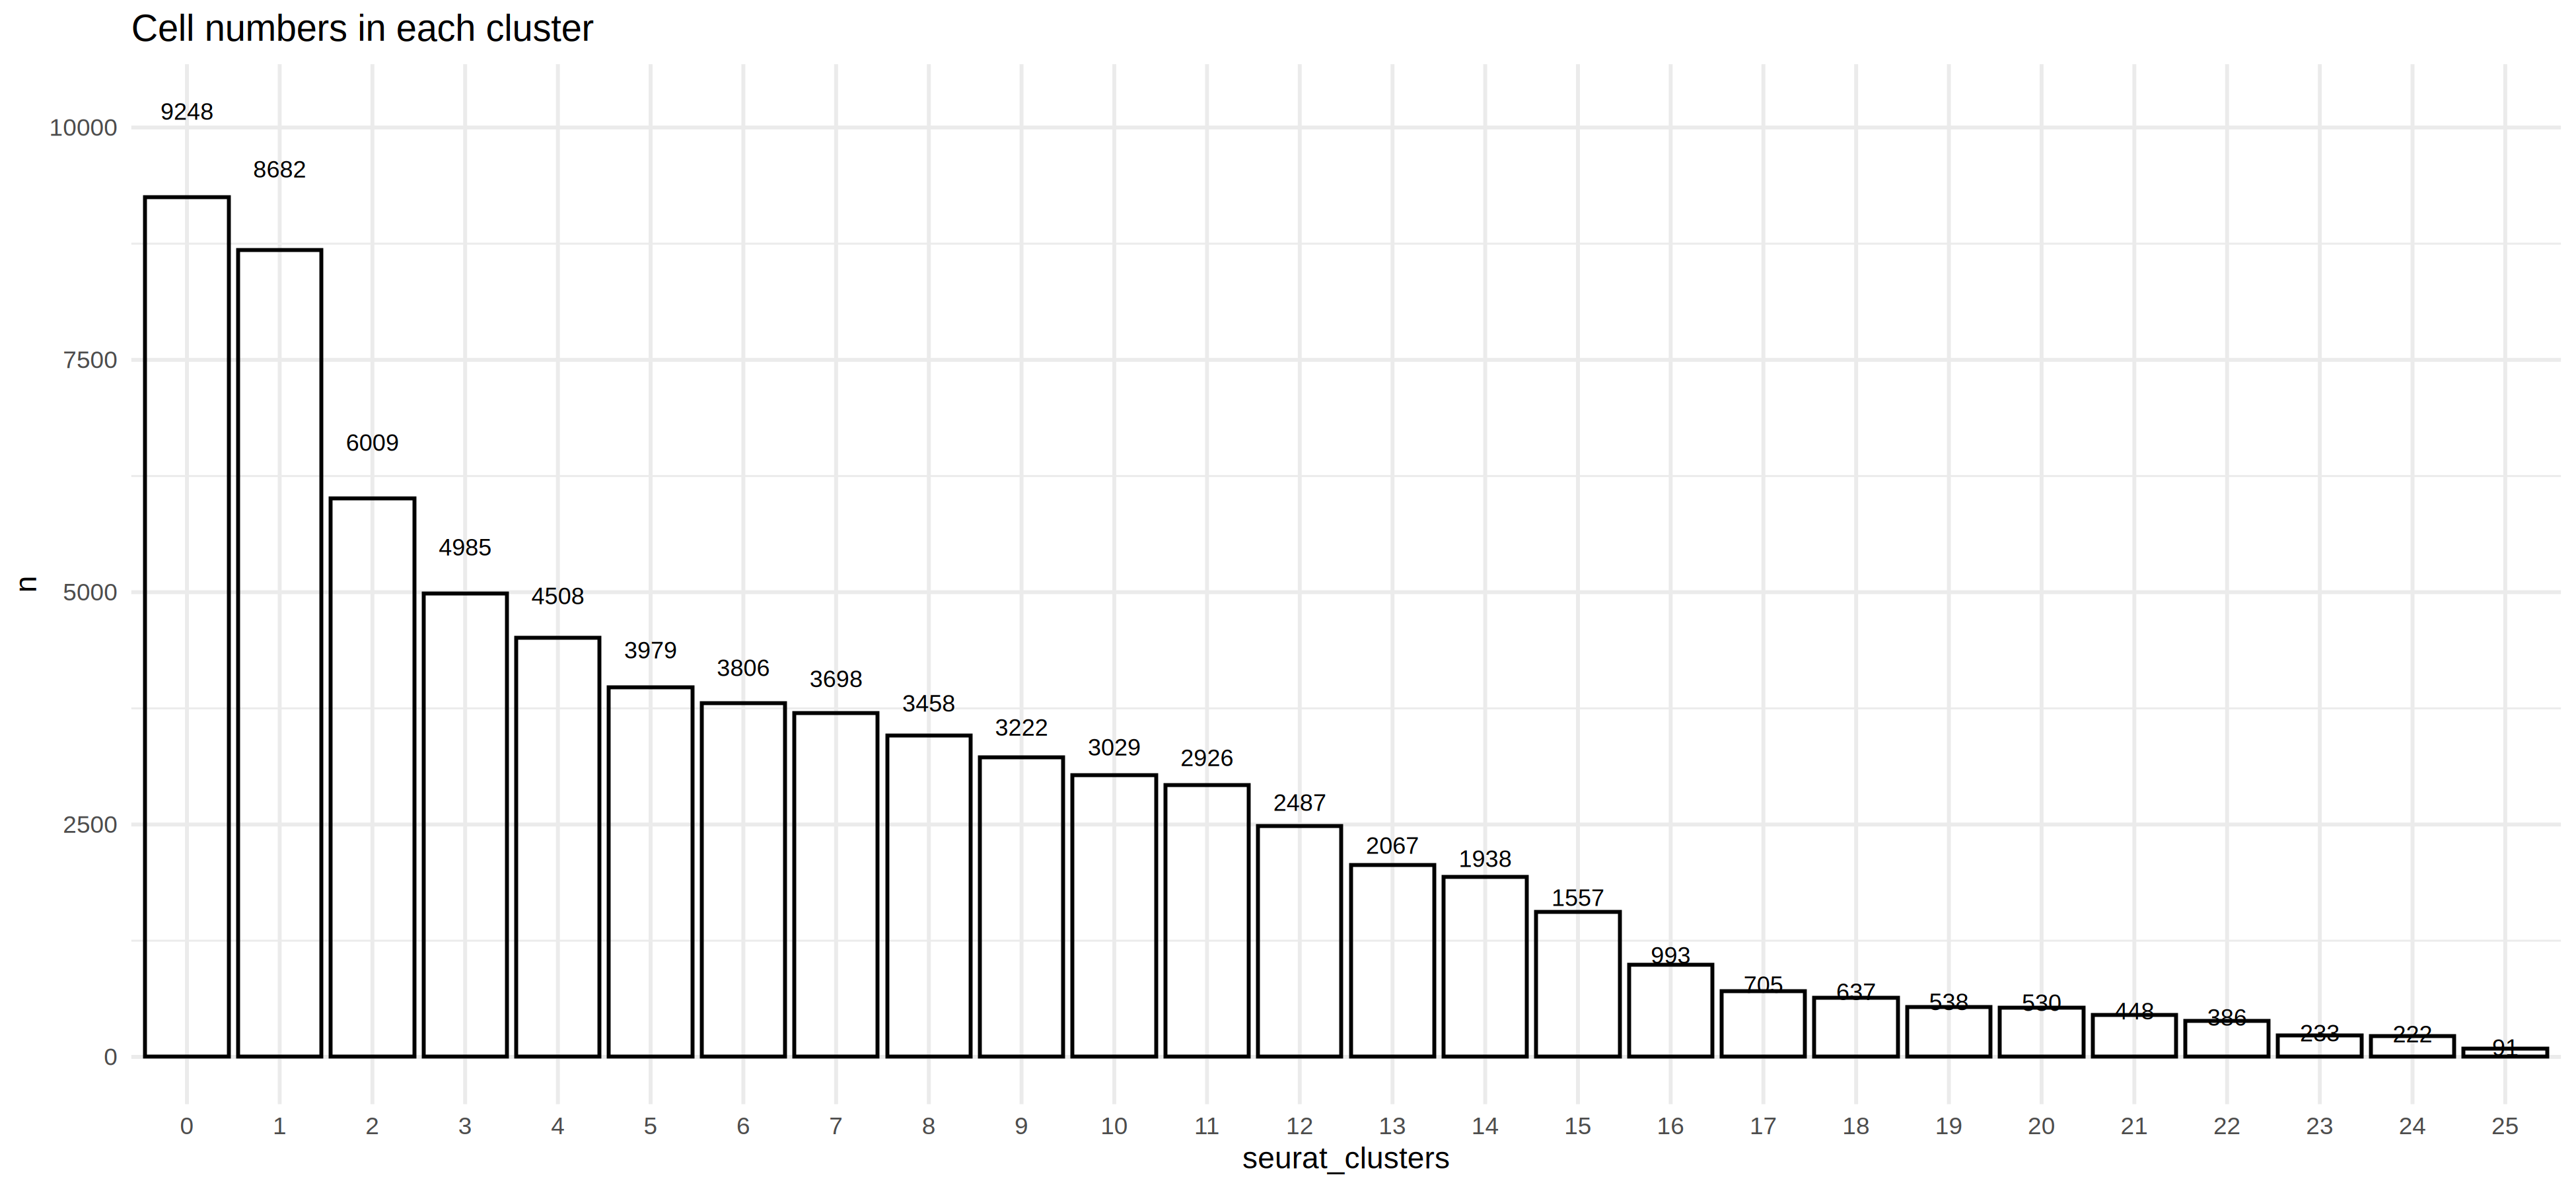

In [13]:
options(repr.plot.width = 13, repr.plot.height = 6, repr.plot.res = 300)
seu_obj@meta.data %>%
  group_by(seurat_clusters) %>%
  count() %>%
  ggplot(aes(x=seurat_clusters,y=n)) +
  geom_col(fill=NA,color='black') +
    geom_text(aes(label = n),
              position = position_stack(vjust = 1.1),size=3)+
    theme_minimal()+
  ggtitle("Cell numbers in each cluster")

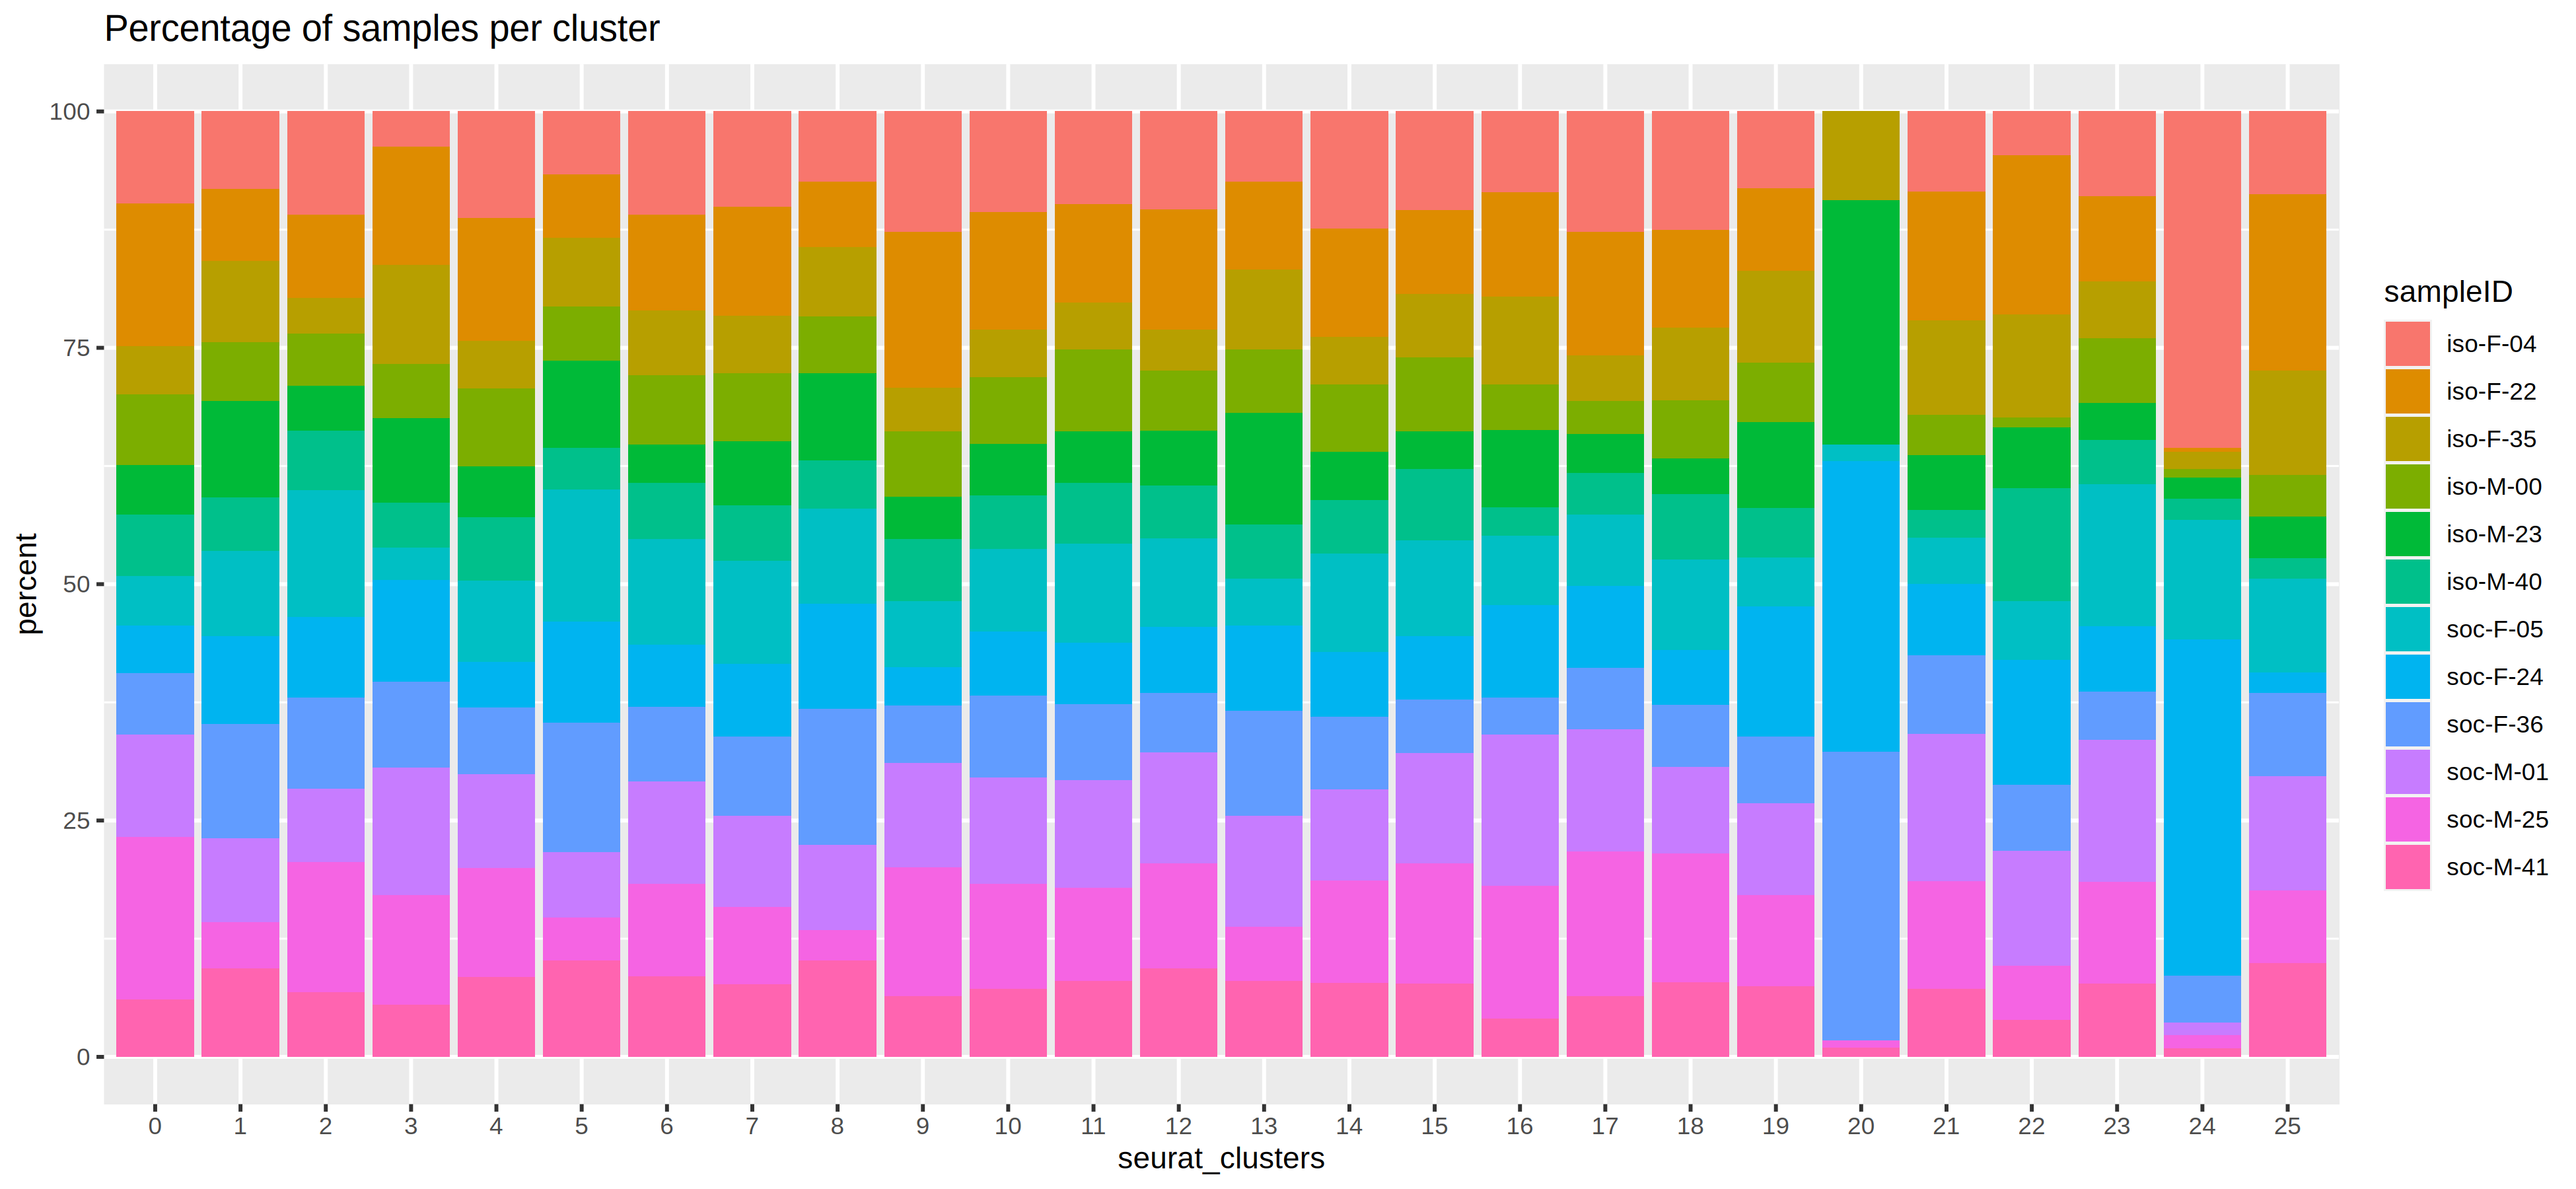

In [14]:
seu_obj@meta.data %>%
  group_by(seurat_clusters,sampleID) %>%
  count() %>%
  group_by(seurat_clusters) %>%
  mutate(percent=100*n/sum(n)) %>%
  ungroup() %>%
  ggplot(aes(x=seurat_clusters,y=percent, fill=sampleID)) +
  geom_col() +
  ggtitle("Percentage of samples per cluster")

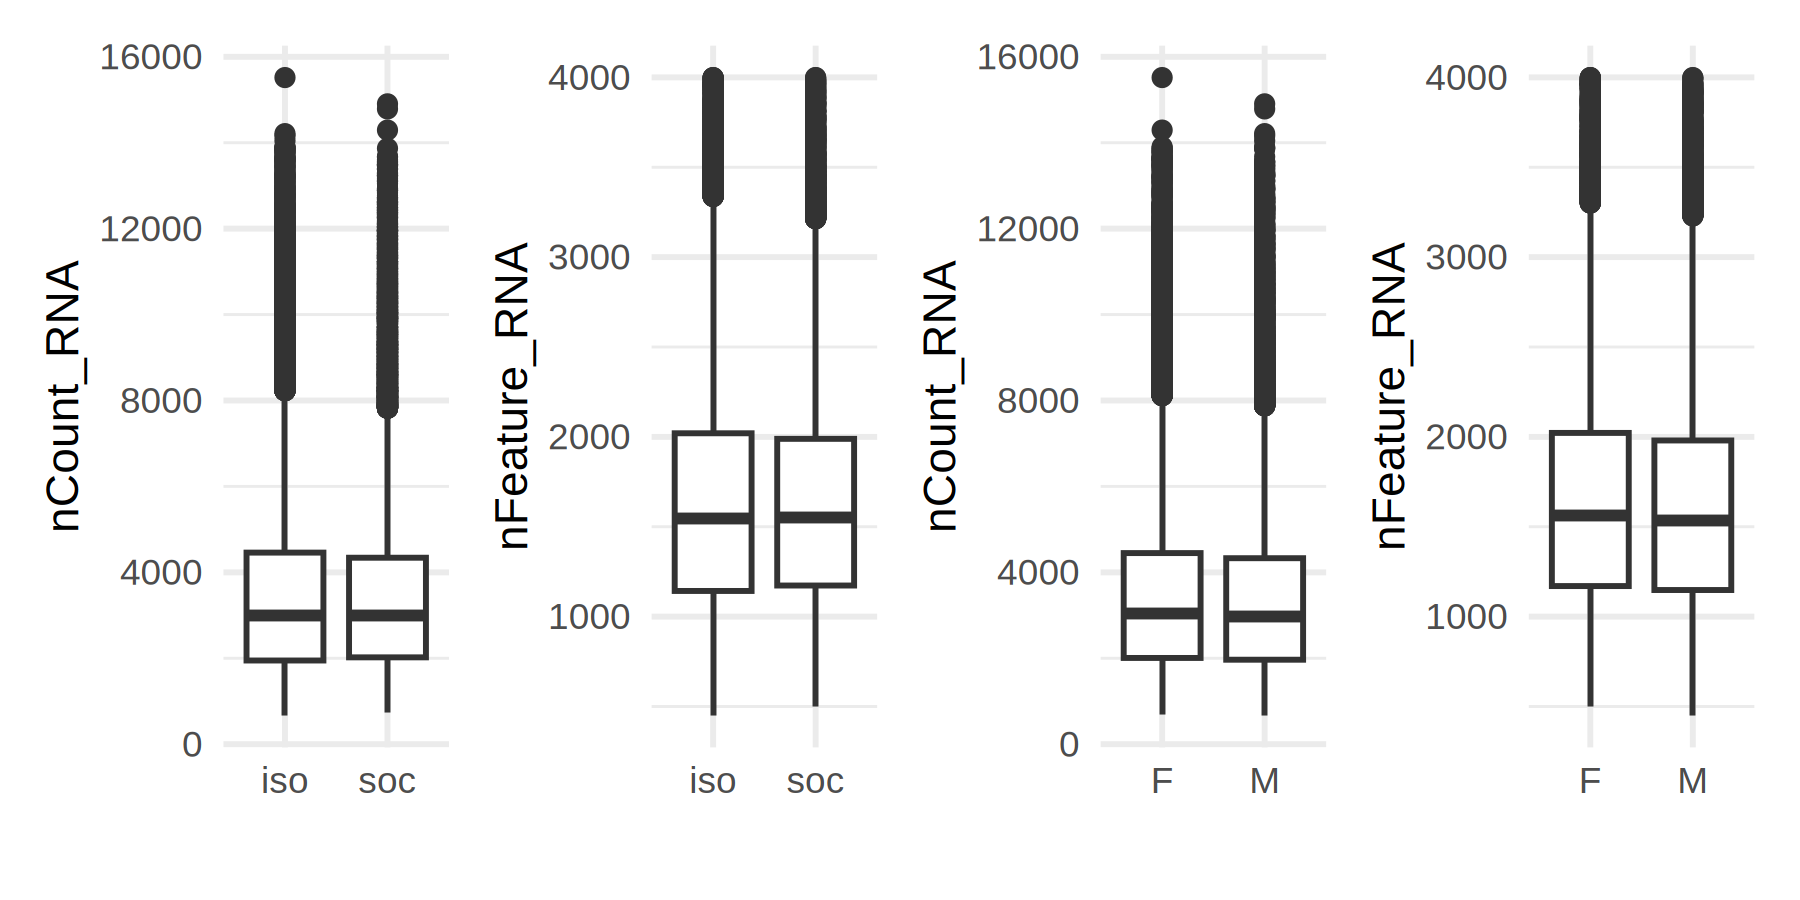

In [15]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res = 300)
p1 <- seu_obj@meta.data %>%
    ggplot(aes(x=group,y=nCount_RNA))+
    geom_boxplot()+
    theme_minimal()+
    scale_x_discrete(name="")

p2 <- seu_obj@meta.data %>%
    ggplot(aes(x=group,y=nFeature_RNA))+
    geom_boxplot()+
    theme_minimal()+
    scale_x_discrete(name="")
p3 <- seu_obj@meta.data %>%
    ggplot(aes(x=sex,y=nCount_RNA))+
    geom_boxplot()+
    theme_minimal()+
    scale_x_discrete(name="")

p4 <- seu_obj@meta.data %>%
    ggplot(aes(x=sex,y=nFeature_RNA))+
    geom_boxplot()+
    theme_minimal()+
    scale_x_discrete(name="")

p1|p2|p3|p4


In [20]:
## make plot highlighting each cluster
pdf("./cluster_highlight_plot_2.pdf", onefile = TRUE)
for(cell_cluster in sort(unique(seu_obj@meta.data$seurat_clusters))){    
    p <- 
    scCustomize::Cluster_Highlight_Plot(
      seu_obj,
      cluster_name=cell_cluster,
      highlight_color = "red",
      background_color = "lightgray",
      pt.size = NULL,
      aspect_ratio = NULL,
      figure_plot = FALSE,
      raster = NULL,
      raster.dpi = c(512, 512)
    )
    print(p)
}
dev.off()

png 
  2

In [ ]:
pdf("./celltype_marker_plots_recluster_2.pdf", onefile = TRUE)
for (i in seq(length(sel.gene))) {
   p <- make_scatterplot(seu_obj,sel.gene[i])
    print(p)
}
dev.off()

In [ ]:
pdf("./cluster_marker_plots_recluster_2.pdf", onefile = TRUE)
for (i in seq(length(top10$gene))) {
   p <- make_scatterplot(seu_obj,top10$gene[i])
    print(p)
}
dev.off()

## Cell type annotation

### Add celltype information into metadata
The celltype are annotated manually based on the marker genes expressed in each cell cluster

In [17]:
seu_obj@meta.data$sampleGroup <- paste(seu_obj@meta.data$group,seu_obj@meta.data$sex,sep="-")

In [18]:
seu_obj@meta.data <-  
seu_obj@meta.data %>%
mutate(celltype =case_when(seurat_clusters %in% c("1","25") ~ "L6 CT",
             seurat_clusters %in% c("0","2") ~ "L2/3 IT",
             seurat_clusters %in% c("3","9") ~ "L4 IT",
              seurat_clusters == "5" ~ "OPC",
                seurat_clusters == "6" ~ "Pvalb-Inh",      
              seurat_clusters == "7" ~ "L5 ET",
              seurat_clusters %in% c("8","11","12","13") ~ "L6 IT",
              seurat_clusters == "10" ~ "Sst-Inh",
                seurat_clusters == "14" ~ "L5/6 NP",
                seurat_clusters %in% c("4") ~ "L5 IT",
                seurat_clusters %in% c("15","23") ~ "CGE-Inh",
              seurat_clusters %in% c("16","17") ~ "ASC",
              seurat_clusters %in% c("19") ~ "ODC",
              seurat_clusters == "20" ~ "STR",
              seurat_clusters == "21" ~ "ODC",
              seurat_clusters == "18" ~ "Endo",
              seurat_clusters %in% c("22","24") ~ "NA"
             ))

In [19]:
unique(seu_obj@meta.data$celltype)

[1] "Sst-Inh"   "L6 IT"     "L5/6 NP"   "L4 IT"     "CGE-Inh"   "L2/3 IT"  
 [7] "L6 CT"     "ASC"       "L5 ET"     "Pvalb-Inh" "L5 IT"     "Endo"     
[13] "NA"        "ODC"       "OPC"       "STR"

In [20]:
seu_obj = subset(x = seu_obj, subset= celltype %in% c('Sst-Inh','L5 IT','L6 IT','L5/6 NP','L5 ET','L4 IT','CGE-Inh','L2/3 IT','L6 CT','ASC','Pvalb-Inh','Endo','ODC','STR','OPC') )

In [21]:
unique(seu_obj@meta.data$celltype)

[1] "Sst-Inh"   "L6 IT"     "L5/6 NP"   "L4 IT"     "CGE-Inh"   "L2/3 IT"  
 [7] "L6 CT"     "ASC"       "L5 ET"     "Pvalb-Inh" "L5 IT"     "Endo"     
[13] "ODC"       "OPC"       "STR"

In [22]:
seu_obj@meta.data <- seu_obj@meta.data %>%
    mutate(celltype_color=case_when(celltype == "L2/3 IT" ~ "#D9F0A3",
                                  celltype == "L4 IT" ~ "#C77963",
                                  celltype == "L5 IT" ~ "#FDDCFF",
                                    celltype == "L6 IT" ~ "#B832E5",
                                    celltype == "L5/6 NP" ~ "#AD6C49",
                                  celltype == "L5 ET" ~ "#B28D9A",
                                  celltype == "L6 CT" ~ "#0094C2",
                                  celltype == "CGE-Inh" ~ "#CEFF00",
                                  celltype == "Sst-Inh" ~ "#C8C8C8",
                                  celltype == "Pvalb-Inh" ~ "#0640FF",
                                  celltype == "ASC" ~ "#00B7FF",
                                  celltype == "ODC" ~ "#0DFF00",
                                    celltype == "OPC" ~ "#81AA70",
                                  celltype == "STR" ~ "#ADBF00",
                                   celltype == "Endo" ~ "#9E7153"))

In [23]:
celltype_order <- c("L2/3 IT","L4 IT","L5 IT","L6 IT","L5/6 NP","L6 CT","L5 ET","CGE-Inh","Sst-Inh","Pvalb-Inh","ASC","ODC","OPC","Endo","STR")
celltype_label <- c("L2/3 IT","L4 IT","L5 IT","L6 IT","L5/6 NP","L6 CT","L5 ET","CGE-Inh","Sst-Inh","Pvalb-Inh","ASC","ODC","OPC","Endo","STR")
seu_obj@meta.data$celltype <- factor(seu_obj@meta.data$celltype,levels=celltype_order)

In [24]:
saveRDS(seu_obj,file="/project/zhuzhuzhang/lyang/scaleBio_RNA_rat_brain/out_mRatBN/merged_seurat_obj_celltype_annotated_2.rds")

## cell type distribution across samples

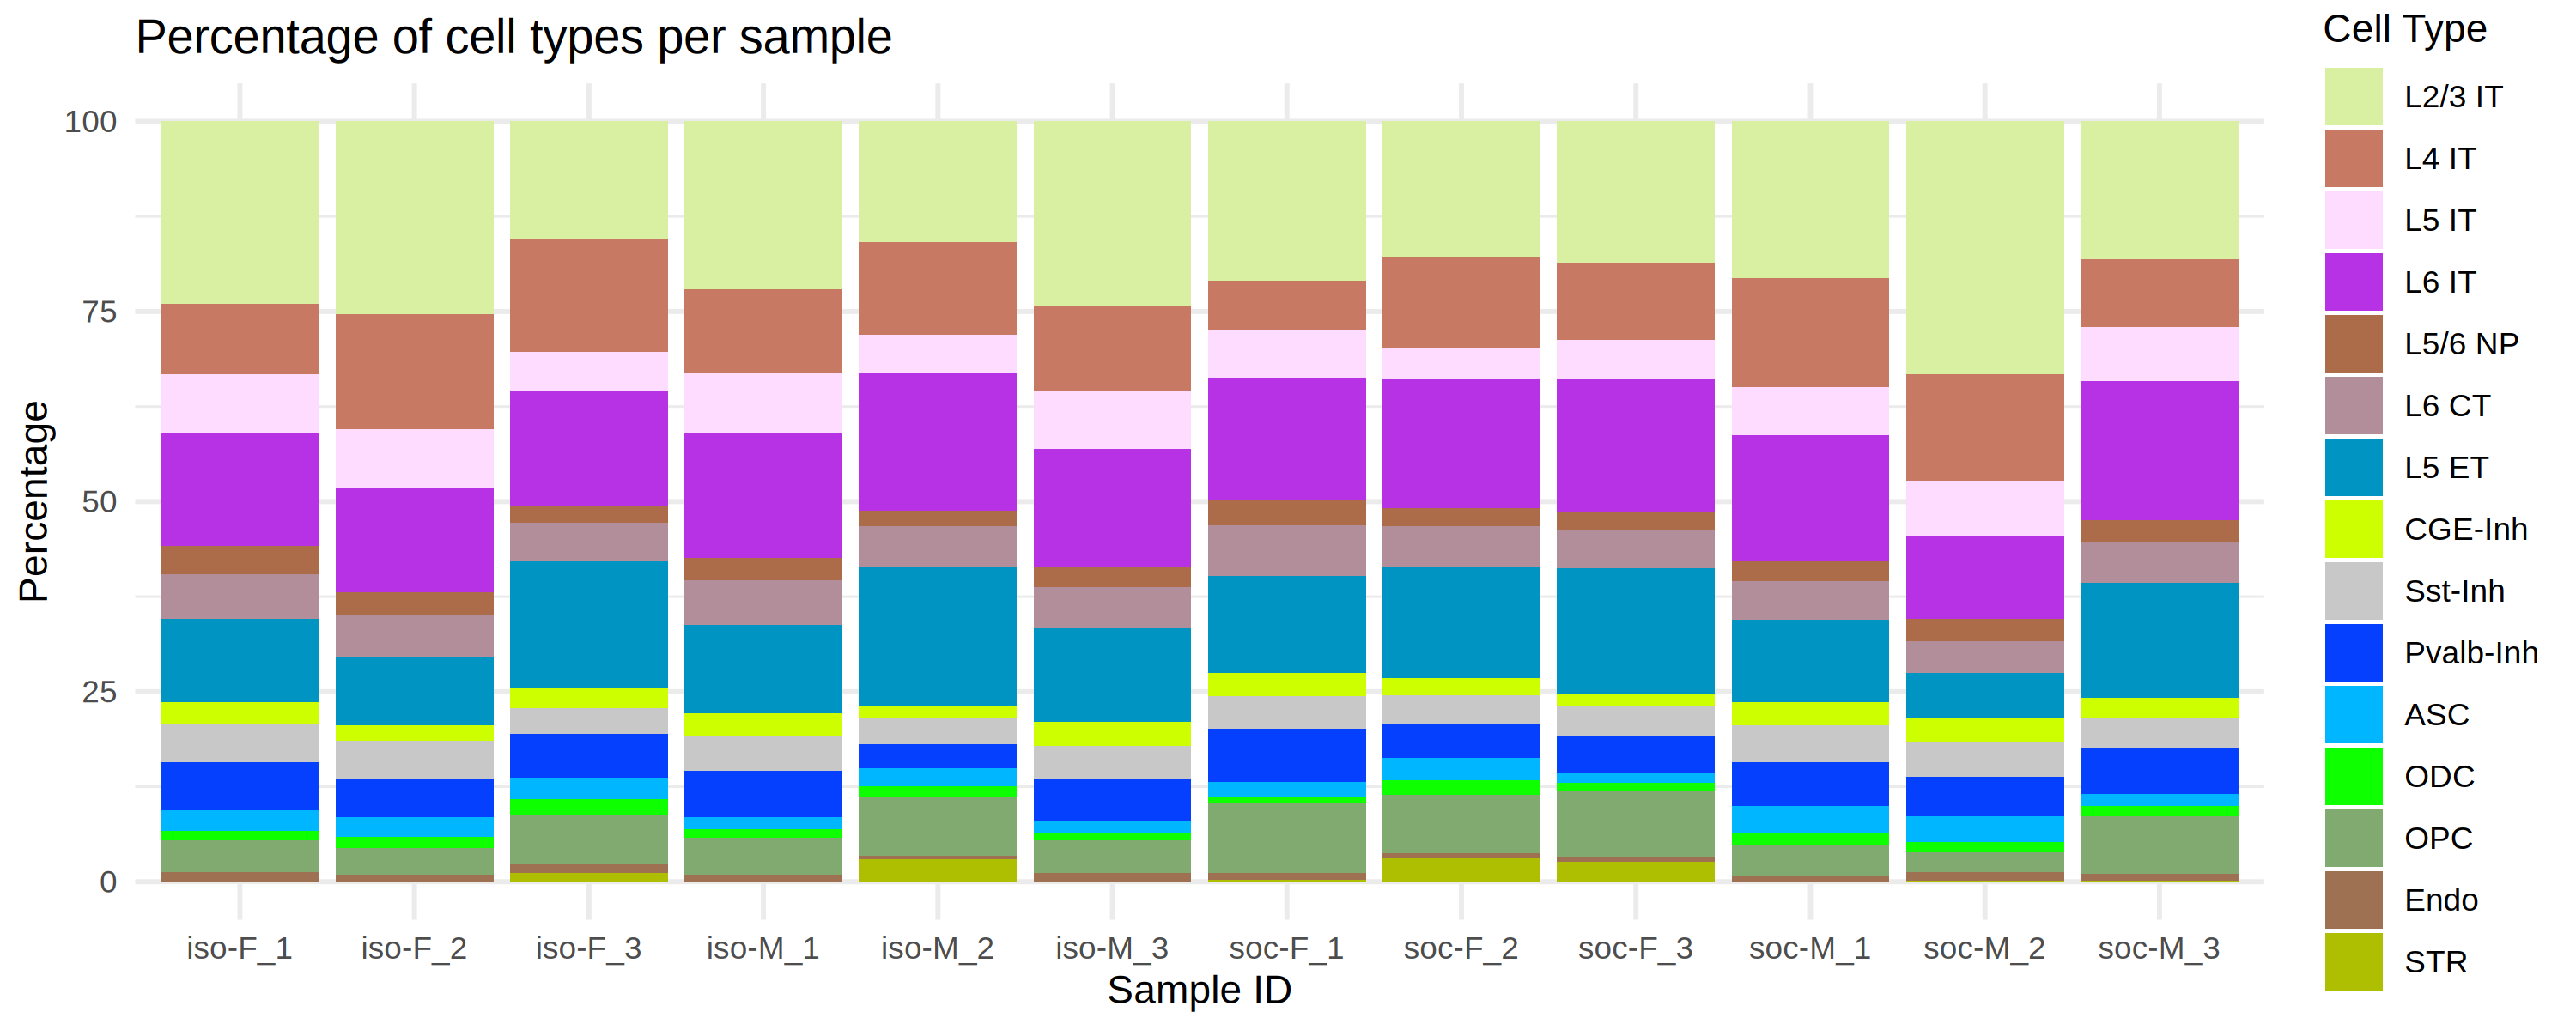

In [27]:
options(repr.plot.width = 10, repr.plot.height = 4, repr.plot.res = 300)
seu_obj@meta.data %>%
  group_by(celltype,sample_name) %>%
  count() %>%
  group_by(sample_name) %>%
  mutate(percent=100*n/sum(n)) %>%
  ungroup() %>%
  mutate(celltype_color=case_when(celltype == "L2/3 IT" ~ "#D9F0A3",
                                  celltype == "L4 IT" ~ "#C77963",
                                  celltype == "L5 IT" ~ "#FDDCFF",
                                    celltype == "L6 IT" ~ "#B832E5",
                                    celltype == "L5/6 NP" ~ "#AD6C49",
                                  celltype == "L5 ET" ~ "#B28D9A",
                                  celltype == "L6 CT" ~ "#0094C2",
                                  celltype == "CGE-Inh" ~ "#CEFF00",
                                  celltype == "Sst-Inh" ~ "#C8C8C8",
                                  celltype == "Pvalb-Inh" ~ "#0640FF",
                                  celltype == "ASC" ~ "#00B7FF",
                                  celltype == "ODC" ~ "#0DFF00",
                                    celltype == "OPC" ~ "#81AA70",
                                  celltype == "Endo" ~ "#9E7153",
                                  celltype == "STR" ~ "#ADBF00"
                                   ))%>%
  mutate(celltype_color=factor(celltype_color,
                               levels=c("#D9F0A3","#C77963","#FDDCFF","#B832E5","#AD6C49","#B28D9A","#0094C2","#CEFF00",
                                        "#C8C8C8","#0640FF","#00B7FF","#0DFF00","#81AA70","#9E7153","#ADBF00"))) %>%
  mutate(celltype=factor(celltype,levels=!!celltype_order,labels=!!celltype_label)) %>%
  ggplot(aes(x=sample_name,y=percent, fill=celltype_color)) +
  geom_col() +
  scale_fill_identity(guide = "legend", labels = celltype_label) +
  ggtitle("Percentage of cell types per sample") +
  theme_minimal() +
  labs(x = "Sample ID", y = "Percentage", fill = "Cell Type")